# oncoPrint: visualizing TCGA Lung Adenocarcinoma Carcinoma Variants Dataset

In [2]:
import os,sys
%matplotlib inline
import matplotlib.pylab as plt
import pickle
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['font.family']='sans serif'
plt.rcParams['font.sans-serif']='Arial'
plt.rcParams['pdf.fonttype']=42
# sys.path.append(os.path.expanduser("~/Projects/Github/PyComplexHeatmap/"))
import PyComplexHeatmap
from PyComplexHeatmap import *

Here, we use the same dataset from R package ComplexHeatmap (https://jokergoo.github.io/ComplexHeatmap-reference/book/oncoprint.html#apply-to-cbioportal-dataset).

In [3]:
data=pd.read_csv("../data/tcga_lung_adenocarcinoma_provisional_ras_raf_mek_jnk_signalling.txt",sep='\t',index_col=0)
data=data.iloc[:,:-1]
data=data.stack().reset_index()
data.columns=['SampleID','Genes','Variants']
data.Variants.replace({'  ':np.nan},inplace=True)

In [4]:
print(data.Variants.dropna().unique())
data.head()

['MUT;' 'AMP;' 'HOMDEL;' 'MUT;AMP;']


,SampleID,Genes,Variants
0,TCGA-05-4384-01,KRAS,NaN
1,TCGA-05-4384-01,HRAS,NaN
2,TCGA-05-4384-01,BRAF,NaN
3,TCGA-05-4384-01,RAF1,NaN
4,TCGA-05-4384-01,MAP3K1,NaN


In [5]:
unique_variants=[]
for var in data.Variants.dropna().unique():
    for v1 in var.split(';'):
        v1=v1.strip()
        if v1=='':
            continue
        if v1 not in unique_variants:
            unique_variants.append(v1)
print(unique_variants)
for var in unique_variants:
    data[var]=data.Variants.fillna('').apply(lambda x:1 if var in x else 0)

['MUT', 'AMP', 'HOMDEL']


In [6]:
data.head()

,SampleID,Genes,Variants,MUT,AMP,HOMDEL
0,TCGA-05-4384-01,KRAS,NaN,0,0,0
1,TCGA-05-4384-01,HRAS,NaN,0,0,0
2,TCGA-05-4384-01,BRAF,NaN,0,0,0
3,TCGA-05-4384-01,RAF1,NaN,0,0,0
4,TCGA-05-4384-01,MAP3K1,NaN,0,0,0


Plot oncoPrint with columns split

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 28.22361111111111 mm


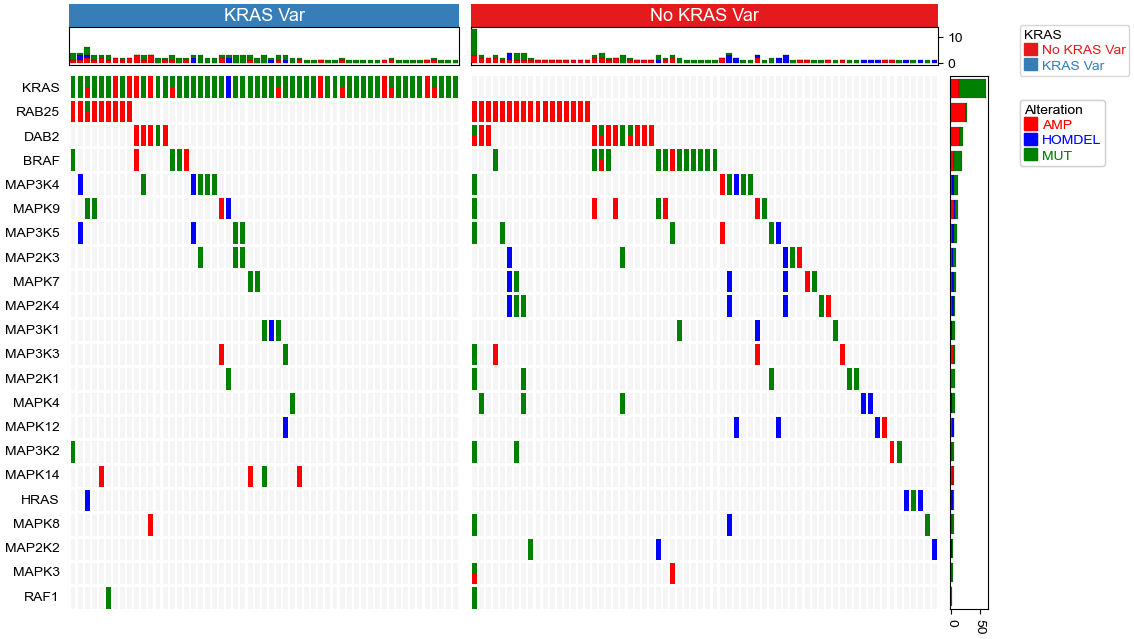

In [7]:
cols=['AMP','HOMDEL','MUT']
colors=["red","blue","#008000"]

# calculate genes (row) mutation frequencies.
row_vc=data.groupby('Genes').apply(lambda x:x.loc[:,cols].sum())
# calculate samples (cols) mutation frequencies.
col_vc=data.groupby('SampleID').apply(lambda x:x.loc[:,cols].sum())

#Samples with variants at KRAS
kras_samples=data.loc[(data.Genes=='KRAS') & (data.loc[:,cols].sum(axis=1)>0)].SampleID.unique().tolist()
df_col_split=pd.DataFrame(index=data.SampleID.unique(),data={'KRAS':['No KRAS Var']*data.SampleID.nunique()})
df_col_split.loc[kras_samples,'KRAS']='KRAS Var'

top_annotation=HeatmapAnnotation(axis=1,
                                KRAS=anno_simple(df_col_split.KRAS,add_text=True,height=6),
                                Col=anno_barplot(col_vc,colors=colors,legend=False,height=10,linewidth=0.1),
                                verbose=0, label_side='left', label_kws={'horizontalalignment': 'right','visible':False})
right_annotation = HeatmapAnnotation(axis=0,orientation='right',
                                Row=anno_barplot(row_vc,colors=colors,legend=False,height=10,linewidth=0.1),
                                verbose=0, label_side='top', label_kws={'horizontalalignment': 'left','rotation':45,'visible':False})
            
plt.figure(figsize=(12,8))
op=oncoPrintPlotter(data=data,y='Genes',x='SampleID',
                    values=cols,colors=colors,subplot_gap=3,label='Alteration',
                    top_annotation=top_annotation,right_annotation=right_annotation,
                    col_split=df_col_split.KRAS,col_split_order=['KRAS Var','No KRAS Var'],col_split_gap=3,
                    legend_hpad=0,show_rownames=True,show_colnames=False) #xticklabels_kws={'labelsize':3}
plt.savefig("oncoPrint.pdf",bbox_inches='tight')
plt.show()

Adding more annotations to the oncoPrint heatmap

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 25.930555555555557 mm


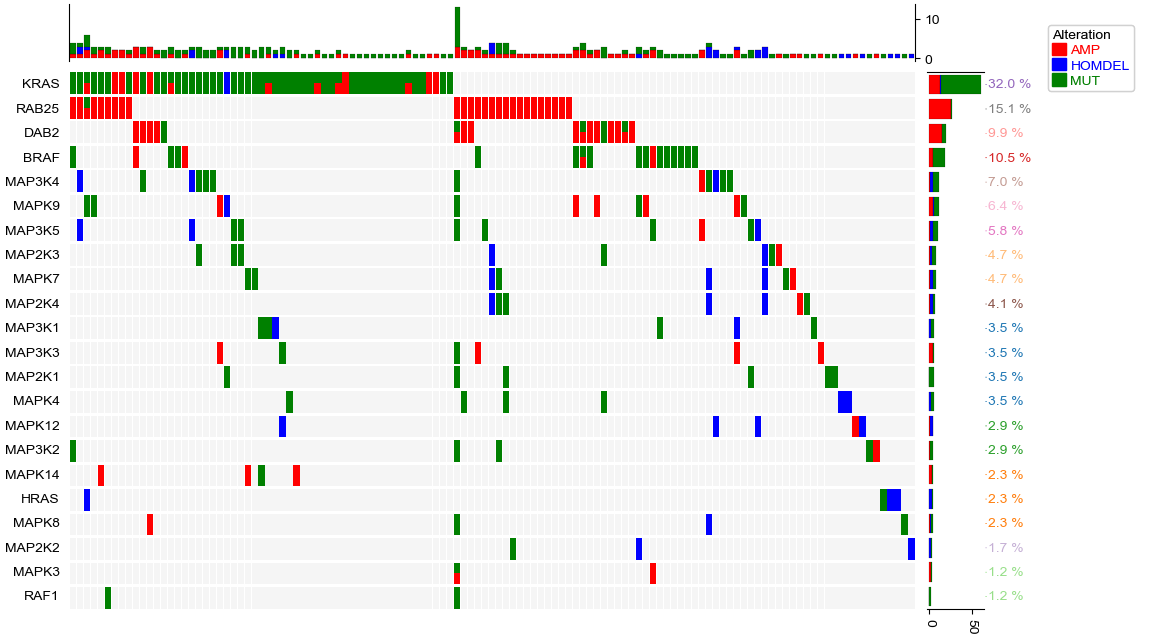

In [8]:
cols=['AMP','HOMDEL','MUT']
colors=["red","blue","#008000"]
row_vc=data.groupby('Genes').apply(lambda x:x.loc[:,cols].sum())
col_vc=data.groupby('SampleID').apply(lambda x:x.loc[:,cols].sum())
row_var_freq=data.assign(IsVar=(data.loc[:,cols].sum(axis=1)>0)).groupby('Genes').IsVar.sum() * 100 / data.SampleID.nunique()

top_annotation=HeatmapAnnotation(axis=1,orientation='up',
                                Col=anno_barplot(col_vc,colors=colors,legend=False,height=15,linewidth=0.1),
                                verbose=0, label_side='left', label_kws={'horizontalalignment': 'right','visible':False})

right_annotation = HeatmapAnnotation(axis=0,orientation='right',
                                Row=anno_barplot(row_vc,colors=colors,legend=False,height=15,linewidth=0.1),
                                label=anno_label(row_var_freq.apply(lambda x:str(round(x,1))+" %"),
                                                 height=1,relpos=(0,0.5)),
                                verbose=0, label_side='top', 
                                label_kws={'horizontalalignment': 'left','rotation':45,'visible':False})
            
plt.figure(figsize=(12,8))
op=oncoPrintPlotter(data=data,y='Genes',x='SampleID',
                    values=cols,colors=colors,subplot_gap=3,label='Alteration',
                    top_annotation=top_annotation,right_annotation=right_annotation,
                   show_rownames=True,show_colnames=False,width=0.9)

# remove the grid
op.top_annotation.annotations[0].ax.grid(False)
#remove spines for top annotation and right annotation
despine(ax=op.top_annotation.annotations[0].ax,left=False, bottom=True, right=False, top=True)
despine(ax=op.right_annotation.annotations[0].ax,left=True, bottom=False, right=True, top=False)

plt.savefig("oncoPrint2.pdf",bbox_inches='tight')
plt.show()